# Advanced Deep Learning Project - Part 2
## Group 8
### Yael Heger, Hila Baram, Ella Tamir

### Imports: 

In [2]:
# Torch:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.quantization as quantization

# Transformers:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, AlbertTokenizer, AlbertModel

# SkLearn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve, accuracy_score, auc, f1_score, precision_score, recall_score  

# Matplotlib:
import matplotlib.pyplot as plt

# Others:
import pandas as pd
import os
import re
import warnings
import string
import nltk
from nltk import corpus
from datasets import Dataset, DatasetDict, load_dataset, load_metric

 Reading the data

In [3]:
# Enter the location of the data localy.

data_neg = 'C:/Users/user/Documents/Advanced Deep Learning/Group8/train_data (1)/train/neg'
data_pos = 'C:/Users/user/Documents/Advanced Deep Learning/Group8/train_data (1)/train/pos'

In [4]:
def read_data_to_list(data_dir):
    # The function receives the path of the files.
    # The function returns a list containing the files paths and a list containing the data.
    
    txt_files = []    # A list to save the opened review files.
    file_paths = []
    for (roots, dirs, files) in os.walk(data_dir): # Reading every file in every folder.     
        for obj in files:  
            file = open(roots + '/'+ obj, 'r', encoding = 'utf-8')
            file_paths.append(roots + '/'+ obj)
            cont = file.read()
            txt_files.append(cont)
            file.close()
    return file_paths, txt_files

In [5]:
neg_files, neg_rev = read_data_to_list(data_neg)   # Negative reviews
pos_files, pos_rev = read_data_to_list(data_pos)   # Positive reviews

Converting to Dataframe

In [6]:
pos_pd = pd.DataFrame(pos_rev, columns=["Review"])
pos_pd

,Review
0,Bromwell High is a cartoon comedy. It ran at t...
1,Homelessness (or Houselessness as George Carli...
2,Brilliant over-acting by Lesley Ann Warren. Be...
3,This is easily the most underrated film inn th...
4,This is not the typical Mel Brooks film. It wa...
...,...
18745,"Seeing as the vote average was pretty low, and..."
18746,"The plot had some wretched, unbelievable twist..."
18747,I am amazed at how this movie(and most others ...
18748,A Christmas Together actually came before my t...


In [7]:
neg_pd = pd.DataFrame(neg_rev, columns=["Review"])

## Pre- Processing 

First, we are cleaning the data from punctuation and converting all letters to lower-case, seperatley for the positive and negative reviews 

In [8]:
string.punctuation

def remove_punctuation(text):
    # The function receives the text to clean.
    # The function clears punctuation marks and other non-alphabetic characters and converts all the text to lower case.
    # The function returns the cleaned data.
    brs = ["br", "<br>", "</br>", " br", "br "]   # To clean all the different shapes that there's in the data. 
    punctuationfree="".join([i for i in text if i not in brs])
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [9]:
pos_pd["Review"] = pos_pd["Review"].apply(lambda x:remove_punctuation(x))
neg_pd["Review"] = neg_pd["Review"].apply(lambda x:remove_punctuation(x))

In [10]:
pos_pd['Review'] = pos_pd['Review'].apply(lambda x: x.lower())
neg_pd['Review'] = neg_pd['Review'].apply(lambda x: x.lower())

Second, we will split the sentences to a list of words. 

In [11]:
def split(text):
    tokens = re.split(' ',text)
    return tokens

In [12]:
pos_pd["Review"] = pos_pd["Review"].apply(lambda x: split(x))
neg_pd["Review"] = neg_pd["Review"].apply(lambda x: split(x))

### removing stop words 

In order to remove stopwords, we are using the stopwords dictionary from nltk

In [13]:
nltk.download('stopwords')
warnings.filterwarnings('ignore')
def remove_stopwords(text):
    stopwords = corpus.stopwords.words('english')
    output= [i for i in text if i not in stopwords]
    return output

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
pos_pd["Review"] = pos_pd["Review"].apply(lambda x:remove_stopwords(x))
neg_pd["Review"] = neg_pd["Review"].apply(lambda x:remove_stopwords(x))

## Exploration 

In [15]:
def length_and_count_data(data):
    # The function receives data and returns its length and a dictionary that contains the number of times each word appears.
    lengths_list = []
    words_dict = {}
    for i in range(len(data)):
        lengths_list.append(len(data[i]))
        split_sentence = data[i]
        for word in split_sentence:
                if word not in words_dict.keys(): # If new word.
                    words_dict[word] = 1
                else:
                    words_dict[word] +=1 # Appears more than once. 
    return lengths_list, words_dict

In [16]:
pos_lengths, pos_dict = length_and_count_data(pos_pd["Review"])
neg_lengths, neg_dict = length_and_count_data(neg_pd["Review"])

### Length histogram for each review type 

In these histograms we can see the expected value of the sentences length, seperated to negative and positive reviews.

y axis - number of words for each length.

x axis - lengths.

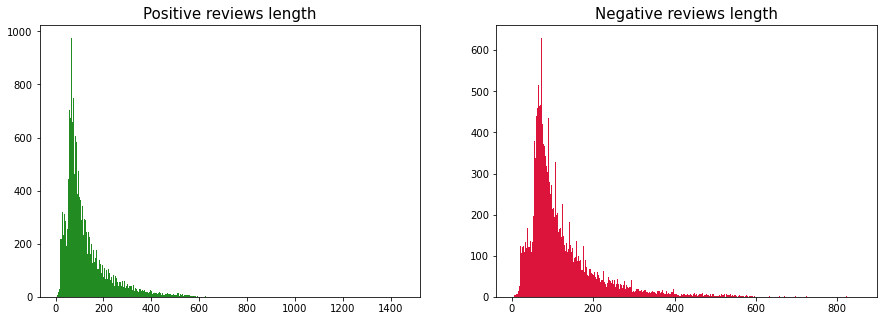

In [17]:
fig, ax = plt.subplots(1,2, figsize=[15,5])
ax[0].hist(pos_lengths, bins = 400, color='forestgreen')
ax[0].set_title("Positive reviews length",{'fontsize':15})
ax[1].hist(neg_lengths, bins = 400, color = "crimson")
ax[1].set_title("Negative reviews length",{'fontsize':15})
plt.show()

### Most Common words 

Now we will check the most common words for each type without removing words that are common in both types of reviews

y axis - number of appearences.

x axis - word.

In [18]:
mc_pos = sorted(pos_dict.items(), key=lambda k_v: k_v[1], reverse=True)[:15]
mc_neg = sorted(neg_dict.items(), key=lambda k_v: k_v[1], reverse=True)[:15]

# Draw the bar chart
def draw_words_hist(mc_pos, mc_neg):
    mc_pos = dict(mc_pos)
    names_pos = list(mc_pos.keys())
    values_pos = list(mc_pos.values())

    mc_neg = dict(mc_neg)
    names_neg = list(mc_neg.keys())
    values_neg = list(mc_neg.values())

    fig, ax = plt.subplots(1,2, figsize=[25,5])
    ax[0].bar(range(len(mc_pos)),values_pos,tick_label=names_pos, color = "forestgreen")
    ax[0].set_title("Positive",{'fontsize':20})
    ax[1].bar(range(len(mc_neg)),values_neg,tick_label=names_neg, color = "crimson")
    ax[1].set_title("Negative",{'fontsize':20})
    plt.show()    

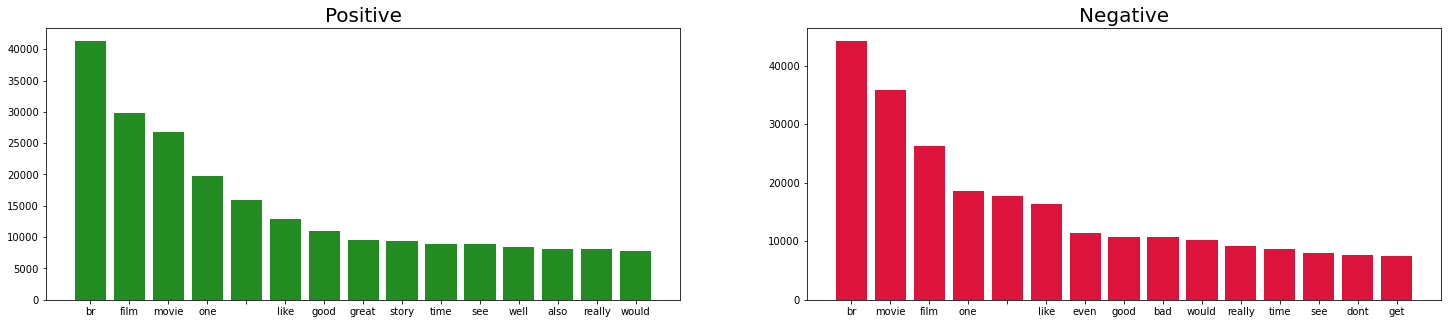

In [19]:
draw_words_hist(mc_pos, mc_neg)

Next we will remove non unique words- if a word is in the top 100 most common words for negative and positive data, we will remove it because it has no contribution to the classification

In [20]:
dict_pos = sorted(pos_dict.items(), key=lambda k_v: k_v[1], reverse=True)
dict_neg = sorted(neg_dict.items(), key=lambda k_v: k_v[1], reverse=True)
word_pos_top_100 = [x[0] for x in dict_pos[:100]] 
word_neg_top_100 = [x[0] for x in dict_neg[:100]] 
count = 0
removed_words = []
flag = True
while count < 100 and flag:
    word = word_pos_top_100[count]
    if word in word_neg_top_100:
        if count == len(word_pos_top_100)-1:
            flag = False
            
        ind_pos = word_pos_top_100.index(word)
        dict_pos.pop(ind_pos)
        word_pos_top_100.pop(ind_pos)
        
        ind_neg = word_neg_top_100.index(word)
        dict_neg.pop(ind_neg)
        word_neg_top_100.pop(ind_neg)
        
        removed_words.append(word)

    else:
        count += 1
        

top_100_pos = dict_pos[:15]
top_100_neg = dict_neg[:15]

In [21]:
print("Number of deleted words: ", len(removed_words))
print("Deleted words:")
print(removed_words)

Number of deleted words:  78
Deleted words:
['br', 'film', 'movie', 'one', '', 'like', 'good', 'great', 'story', 'time', 'see', 'well', 'also', 'really', 'would', 'even', 'much', 'first', 'people', 'films', 'love', 'best', 'get', 'way', 'life', 'many', 'characters', 'think', 'movies', 'made', 'two', 'seen', 'dont', 'character', 'show', 'watch', 'still', 'little', 'make', 'never', 'could', 'man', 'know', 'ever', 'end', 'scene', 'real', 'say', 'back', 'scenes', 'makes', 'acting', 'go', 'better', 'though', 'plot', 'find', 'work', 'lot', 'something', 'another', 'old', 'part', 'actors', 'every', 'funny', 'im', 'watching', 'doesnt', 'look', 'bad', 'things', 'going', 'actually', 'director', 'didnt', 'thing', 'around']


In [22]:
def remove_common_words(text):
    output = [i for i in text if i not in removed_words]
    return output

In [23]:
pos_pd["Review"] = pos_pd["Review"].apply(lambda x:remove_common_words(x))
neg_pd["Review"] = neg_pd["Review"].apply(lambda x:remove_common_words(x))

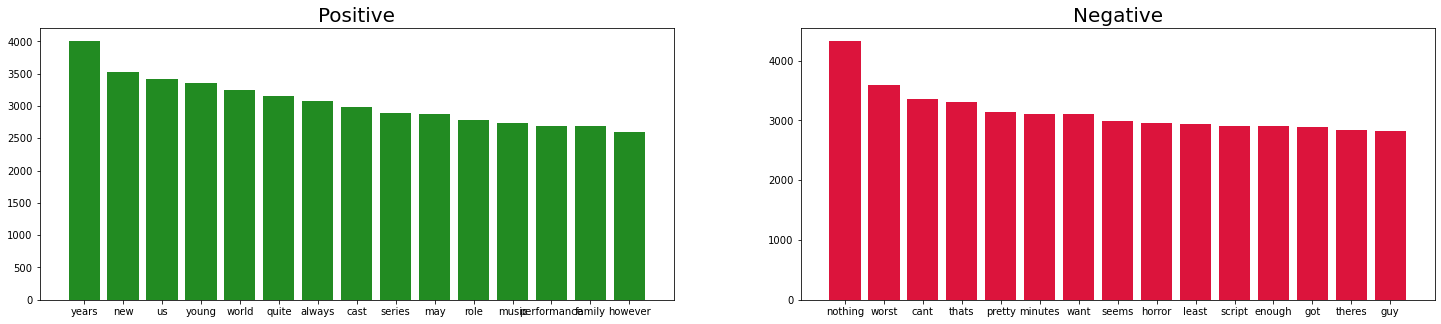

In [24]:
draw_words_hist(top_100_pos, top_100_neg)

In [25]:
# Adding spaces
pos_pd["Review"] = pos_pd["Review"].apply(lambda x:" ".join(x))
neg_pd["Review"] = neg_pd["Review"].apply(lambda x:" ".join(x))

## Models & Training 

In [26]:
# Running on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

split the data to train and test

In [27]:
pos_pd['Labels'] = 1
neg_pd['Labels'] = 0

In [28]:
data = pd.concat([pos_pd["Review"], neg_pd["Review"]])
labels = pd.concat([pos_pd["Labels"], neg_pd["Labels"]])

In [29]:
X_train ,X_test ,y_train ,y_test = train_test_split(data, labels, test_size=0.25, random_state=42, shuffle = True)

In [30]:
train_df = pd.DataFrame(list(zip(X_train, y_train)), columns =['text','labels'])
test_df = pd.DataFrame(list(zip(X_test, y_test)), columns =['text','labels'])

### Defining the Dataset Dict:

Choosing the models

In [31]:
from datasets import load_dataset

In [32]:
raw_datasets = DatasetDict()

raw_datasets['train'] = Dataset.from_pandas(train_df)
raw_datasets['test'] = Dataset.from_pandas(test_df)

### Defining a Pre-trained model as a class 

In [33]:
class Pre_trained_Model():
    
    def __init__(self, name, lr, lossFunc, dataset):
        self.name = name
        self.model = AutoModelForSequenceClassification.from_pretrained(self.name, num_labels = 2)
        self.tokenizer = AutoTokenizer.from_pretrained(self.name)
        self.dataset = dataset
        self.tokenized_dataset = None
        self.tokenized_test = None
        self.lossFunc = lossFunc
        self.lr = lr
        
        # Trying different optimizers: Adam Selected!
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        #self.optimizer = torch.optim.Adagrad(self.model.parameters(), self.lr)
        #self.optimizer = torch.optim.RMSprop(self.model.parameters(), self.lr)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr)

        
    def tokenize(self, parameters):
        self.tokenized_dataset = self.dataset.map(self.tokenizer, input_columns='text', fn_kwargs = parameters)
        for split in self.tokenized_dataset:
                self.tokenized_dataset[split] = self.tokenized_dataset[split].add_column('labels',self.dataset[split]['labels'])
                self.tokenized_dataset[split] = self.tokenized_dataset[split].remove_columns(['text'])
        self.tokenized_dataset.set_format('torch')
        
        
    def training(self, training_args):
        trainer = Trainer( model = self.model, args = training_args, train_dataset = self.tokenized_dataset['train'],
                      eval_dataset = self.tokenized_dataset['test'], compute_metrics = self.metrics)
        trainer.train()

    def predict(self, test_dataset):
        trainer = Trainer(model = self.model, args = training_args, test_dataset = tokenized_test['test'], metrics = self.metrics)
        

        
    def metrics(self, predictions):
        # Calculating eval values: f1 score, accuracy, precision, recall
        preds = predictions.predictions.argmax(axis = 1)
        labels = predictions.label_ids
        return {'f1': f1_score(preds, labels, average = 'binary'),
                'accuracy':accuracy_score(preds, labels),
                'precision_score': precision_score(preds, labels),
                'recall_score': recall_score(preds, labels)}

Trying different loss functions: BCE loss Selected!

In [34]:
loss_func = torch.nn.BCELoss()
# loss_func = torch.nn.L1Loss()
# loss_func = torch.nn.MSELoss()
# loss_func = torch.nn.CosineEmbeddingLoss()
# loss_func = torch.nn.CrossEntropyLoss()
# loss_func = torch.nn.KLDivLoss()
# loss_func = torch.nn.BCEWithLogitsLoss()

Defining the training arguments for the training (replace out path with a local path)

In [35]:
OUT_PATH = r"D:/Users/ela86/Documents/"
args = TrainingArguments(output_dir = OUT_PATH,
                         overwrite_output_dir = True,
                         per_device_train_batch_size = 32,
                         per_device_eval_batch_size = 32,
                         learning_rate = 0.00001,
                         weight_decay = 0.01,
                         save_strategy = 'no',
                         metric_for_best_model = 'dev_f1',
                         greater_is_better = True,
                         evaluation_strategy = 'epoch',
                         do_train = True,
                         num_train_epochs = 5,
                         gradient_accumulation_steps = 5,
                         fp16 = True,
                         logging_strategy = 'epoch',
                         report_to = 'none')

## Defining Albert and Bert models 

### Albert model: 

In [36]:
warnings.filterwarnings('ignore')
model_name = 'albert-base-v2'
model_albert = Pre_trained_Model(model_name, 0.00001, loss_func, raw_datasets)
model_albert.tokenize({"max_length": 200, "truncation": True, "padding": "max_length"})
model_albert.tokenized_dataset

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

  0%|          | 0/28125 [00:00<?, ?ex/s]

  0%|          | 0/9375 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 28125
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9375
    })
})

In [37]:
warnings.filterwarnings('ignore')
model_albert.training(args)

Using amp half precision backend
***** Running training *****
  Num examples = 28125
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 5
  Total optimization steps = 875


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Score,Recall Score
0,0.405900,0.318558,0.876556,0.870933,0.919127,0.837754
1,0.284400,0.287625,0.876988,0.878720,0.867137,0.887065
2,0.224500,0.303154,0.877010,0.879253,0.863500,0.890949
3,0.164100,0.327066,0.872798,0.873707,0.869063,0.876565
4,0.116100,0.357234,0.865624,0.865280,0.870347,0.860952


***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




### Bert model: 

In [38]:
warnings.filterwarnings('ignore')
model_name2 = "distilbert-base-uncased"
model_bert = Pre_trained_Model(model_name2, 0.001, loss_func, raw_datasets)
model_bert.tokenize({"max_length": 200, "truncation": True, "padding": "max_length"})
model_bert.tokenized_dataset

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\user/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\user/.cache\huggingface\transforme

  0%|          | 0/28125 [00:00<?, ?ex/s]

  0%|          | 0/9375 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28125
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9375
    })
})

In [39]:
warnings.filterwarnings('ignore')
model_bert.training(args)

Using amp half precision backend
***** Running training *****
  Num examples = 28125
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 5
  Total optimization steps = 875


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Score,Recall Score
0,0.438500,0.333266,0.864587,0.859733,0.898160,0.833433
1,0.309000,0.319619,0.855982,0.863893,0.811297,0.905877
2,0.272700,0.299958,0.878670,0.877013,0.893239,0.864568
3,0.244400,0.293364,0.878244,0.879893,0.868849,0.887844
4,0.230300,0.294145,0.880919,0.881707,0.877621,0.884242


***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




In [40]:
print(torch.cuda.memory_summary(abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  625258 KB |    7182 MB |  212112 GB |  212111 GB |
|       from large pool |  623360 KB |    7177 MB |  212055 GB |  212054 GB |
|       from small pool |    1898 KB |       4 MB |      57 GB |      57 GB |
|---------------------------------------------------------------------------|
| Active memory         |  625258 KB |    7182 MB |  212112 GB |  212111 GB |
|       from large pool |  623360 KB |    7177 MB |  212055 GB |

# Compression 

In [41]:
def print_size_of_model(model): # Checking the size of the model.
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

## 1) Prune - Albert model 

In [49]:
model_seq_classification = model_albert.model

In [50]:
print_size_of_model(model_seq_classification)

Size (MB): 46.755601


In [51]:
def prune(model, amount1, amount2): # The pruning function, pruning the layers of the model.
    for name, module in model_seq_classification.named_parameters():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name = 'weight', amount = amount1)
        # prune 40% of connections in all linear layers
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name = 'weight', amount = amount2)

### first pruning: 

In [52]:
prune(model_seq_classification, 0.35, 0.45)

In [53]:
print_size_of_model(model_seq_classification)

Size (MB): 46.755601


In [55]:
# Training after first pruning:
model_albert.training(args)

Using amp half precision backend
***** Running training *****
  Num examples = 28125
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 5
  Total optimization steps = 875


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Score,Recall Score
0,0.151700,0.366621,0.869556,0.864213,0.907788,0.834415
1,0.101700,0.431186,0.854958,0.858347,0.837398,0.873271
2,0.069600,0.464223,0.868399,0.866027,0.886607,0.850924
3,0.047600,0.511997,0.863805,0.862933,0.871844,0.855913
4,0.035100,0.563145,0.859007,0.859413,0.859007,0.859007


***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




### second pruning: 

In [57]:
prune(model_seq_classification, 0.35, 0.45)

In [58]:
print_size_of_model(model_seq_classification)

Size (MB): 46.755601


In [62]:
# Training after second pruning:
model_albert.training(args)

Using amp half precision backend
***** Running training *****
  Num examples = 28125
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 5
  Total optimization steps = 875


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision Score,Recall Score
0,0.072200,0.474268,0.869896,0.868480,0.881900,0.858214
1,0.055200,0.551341,0.858027,0.863040,0.830124,0.887872
2,0.035100,0.609081,0.862025,0.860480,0.874198,0.850187
3,0.023000,0.673225,0.859714,0.858667,0.868635,0.850975
4,0.014500,0.715280,0.860346,0.860480,0.862003,0.858696


***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32
***** Running Evaluation *****
  Num examples = 9375
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




## Prediction - Albert: 

## 2) Quantization - Bert model

In [43]:
model_seq_classification = model_bert.model

In [44]:
print_size_of_model(model_seq_classification)

Size (MB): 267.860529


In [45]:
model_seq_classification = model_bert.model
model_seq_classification.to('cpu')
quantization.quantize_dynamic(model_seq_classification, {torch.nn.Linear}, dtype = torch.qint8)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (k_lin): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (v_lin): DynamicQuantizedLinear(in_features=768, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (out_lin): DynamicQuantizedLinear(in_features=768, out_features=768,

In [46]:
print_size_of_model(model_seq_classification)

Size (MB): 267.859057


In [47]:
model_seq_classification.to("cuda")

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

## Predictiction - Bert: 